Synthetic problem generator: Model I

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
import matplotlib.pyplot as plt
from pymoo.core.repair import Repair


In [14]:
class HSEProblem_1(ElementwiseProblem):
    def __init__(self, 
                 data, 
                 candidate_data, 
                 d_ij,
                 p_candidates, 
                 coverage, 
                 d_thres,
                 predicted_feature_col, 
                 demand_col, 
                 access_score_col, 
                 **kwargs):

        # Number of candidates and demands
        self.y_height = len(candidate_data)
        self.y_width = len(d_ij.drop('region', axis=1).columns)

        # Number of decision variables for candidates and coverage matrix
        self.n_var_x = len(candidate_data)
        self.n_var_y = self.y_height * self.y_width
        self.coverage = coverage

        # Total number of decision variables (flattened coverage matrix)
        self.n = self.n_var_x

        # Column names
        self.predicted_feature_col = predicted_feature_col
        self.demand_col = demand_col
        self.access_score_col = access_score_col

        # Initialise the problem with number of variables, objectives, and constraints
        super().__init__(n_var=self.n,
                         n_obj=3,
                         n_ieq_constr=1 + self.n_var_y,
                         n_eq_constr=1 + self.y_width,
                         xl=0,
                         xu=1,
                         **kwargs)

        # Decision variable bounds: 0 to 1
        self.xl = np.zeros(self.n)
        self.xu = np.ones(self.n)

        # Store the provided data for evaluation
        self.data = data
        self.candidate_data = candidate_data
        self.d_ij = d_ij
        self.p_candidates = p_candidates
        self.d_thres = d_thres

    def _evaluate(self, x, out, *args, **kwargs):
        # Import data sets for evaluation
        op_data = self.data
        d_ij = self.d_ij

        # Extract relevant data from the input data sets
        mpr = np.array(op_data[self.predicted_feature_col])     # MPR data
        demand_i = np.array(op_data[self.demand_col])           # Demand data
        access_score = np.array(op_data[self.access_score_col]) # Perceived accesibility score data
        d_thres = self.d_thres                                  # Distance threshold
        d_ij = d_ij.drop('region', axis=1).values               # Demand matrix

        # Extract decision variables
        xi = x[:self.n_var_x] # Candidate variables

        y_vars = np.zeros((self.y_height, self.y_width), dtype=int)

        d_ij_values = d_ij * np.where(xi == 0, 1000, xi)[:, np.newaxis]

        # Iterate through each demand (width)
        for j in range(self.y_width):  # Iterate over demands
            # Find the nearest candidate (min distance)
            nearest_candidate = np.argmin(d_ij_values[:, j])
            
            # Assign the nearest candidate (1 for the nearest, 0 for others)
            y_vars[:, j] = 0  # Set all to 0 first
            y_vars[nearest_candidate, j] = 1  # Set the nearest to 1

        yij = y_vars

        # Define objective functions
        # Objective 1: Minimise demand weighted distance
        f1 = np.sum(demand_i * np.sum(d_ij * yij, axis=1))
        # Objective 2: Maximise perceived accesibility
        f2 = -1 * np.sum((1 / access_score) * demand_i * xi)
        # Objective 3: Maximise MPR
        f3 = -1 * np.sum(mpr * xi)


        # Inequality constraint  2: Coverage matrix should be consistent with the candidate locations
        iec2 = np.zeros((self.y_height * self.y_width) + 1)
        idx = 0
        for i in range(self.y_height):
            for j in range(self.y_width):
                iec2[idx] = int(yij[i][j]) - int(xi[i])
                idx += 1

        # Inequality constraint 3: Coverage ratio should meet the desired coverage
        iec3 = self.coverage - np.count_nonzero(np.any((d_ij * yij * (d_ij <= d_thres)) > 0, axis=0)) / self.y_width
        iec2[len(iec2) - 1] = iec3
        iec2_list = iec2.tolist()

        ec1 = 1 - np.sum(yij, axis=0)
        ec1_list = ec1.flatten().tolist()
        ec2 = np.sum(xi) - self.p_candidates

        # Output objectives, inequality constraints, and equality constraints
        f = [f1, f2, f3]
        g = iec2_list
        h =  ec1_list + [ec2]

        out["F"] = f
        out["G"] = g
        out["H"] = h

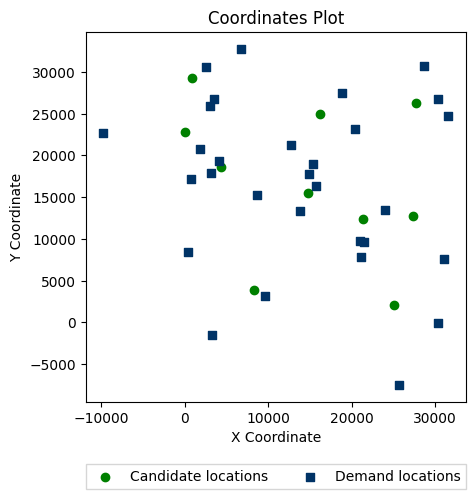

In [16]:
### Repair functions ###

# ClipRepair class that inherits from a Repair class (likely from a library).
# This repair ensures that each value in a population is clipped between a lower (xl) and upper (xu) bound and converted to integers.
class ClipRepair(Repair):
    def __init__(self, xl, xu):
        super().__init__()
        self.xl = xl  # lower bound for clipping
        self.xu = xu  # upper bound for clipping

    # Function that repairs a population by clipping it within the specified bounds
    def _do(self, problem, pop, **kwargs):
        return np.clip(pop, self.xl, self.xu).astype(int)  # Clip the values to the given bounds and convert to integers

# CustomRepair class that combines multiple repairs (e.g., ClipRepair, AssignmentRepair).
class CustomRepair(Repair):
    def __init__(self, xl, xu, width, height):
        super().__init__()
        self.clip_repair = ClipRepair(xl, xu)  # Initialize clip repair with the given bounds
        # self.assignemt_repair = AssignmentRepair(n, width, height)  # Another repair option (commented out)

    # Combines multiple repair strategies, starting with clip repair
    def _do(self, problem, pop, **kwargs):
        pop = self.clip_repair._do(problem, pop, **kwargs)  # Apply clip repair to the population
        # pop = self.assignemt_repair._do(problem, pop, **kwargs)  # Could apply assignment repair next (if uncommented)
        return pop  # Return the repaired population


### Functions to generate random problems ###

# Generates random coordinates for a set of candidates and demand points
def generate_coordinates(num_candidates, num_demands, distance, seed):
    random.seed(seed)  # Set random seed for reproducibility

    # Function to generate random points (used for demand generation)
    def generate_set(num_points):
        points = []
        for _ in range(num_points):
            x = random.randint(0, distance)  # Random x-coordinate within the given range
            y = random.randint(0, distance)  # Random y-coordinate within the given range
            points.append((x, y))  # Append the (x, y) coordinate
        return points

    # Function to generate demand points near candidates within a certain distance range
    def generate_set_near_candidates(candidates, num_points_range=(2,4), min_distance=500, max_distance=10000):
        all_points = []

        for candidate in candidates:
            num_points = random.randint(num_points_range[0], num_points_range[1])  # Randomly choose number of demand points near a candidate
            candidate_points = []

            while len(candidate_points) < num_points:
                angle = random.uniform(0, 2 * math.pi)  # Random angle to place the demand point
                distance = random.uniform(min_distance, max_distance)  # Random distance from the candidate
                x = candidate[0] + distance * math.cos(angle)  # Calculate x-coordinate
                y = candidate[1] + distance * math.sin(angle)  # Calculate y-coordinate
                candidate_points.append((x, y))  # Add the generated point

            all_points.extend(candidate_points)  # Add all points for the candidate

        return all_points

    # Helper function to calculate the Euclidean distance between two points
    def euclidean_distance(p1, p2):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Function to generate candidate points, ensuring minimum distance between them
    def generate_set_candidates(num_candidates, distance, min_distance):
        points = []
        while len(points) < num_candidates:
            x = random.randint(0, distance)  # Random x-coordinate
            y = random.randint(0, distance)  # Random y-coordinate

            # Ensure the point is valid by checking distance from all existing points
            valid = all(euclidean_distance((x, y), p) >= min_distance for p in points)

            if valid:
                points.append((x, y))  # Add the candidate point if valid

        return points

    # Generate candidate locations and demand locations
    candidates = generate_set_candidates(num_candidates, distance, min_distance=5000)
    # Demands are generated near candidate locations using a specific function
    demands = generate_set_near_candidates(candidates, num_points_range=(num_demands, num_demands))

    # Generate additional attributes such as market share, demand, access score, and economically active population
    market_shares = [random.uniform(0.01, 6) for i in range(num_candidates)] 
    demand = [random.randint(140000, 600000) for i in range(num_candidates)] 
    access_score = [random.uniform(4, 10) for i in range(num_candidates)] 
    economic_active = [round(demand[i] * random.uniform(0.3, 0.55)) for i in range(num_candidates)]

    # Create a DataFrame with these attributes
    data = {
        'region': ['region_{}'.format(i + 1) for i in range(num_candidates)],
        'market_share': market_shares,
        'demand': demand,
        'access_score': access_score,
        'economic_active': economic_active
    }

    df = pd.DataFrame(data)  # Convert data to a pandas DataFrame

    return candidates, demands, df  # Return candidate locations, demand locations, and the dataset

# Function to calculate the distance matrix (Euclidean distance) between candidates and demands
def euclidean_distance_matrix(candidates, demands):
    candidates = np.array(candidates)
    demands = np.array(demands)
    num_candidates = candidates.shape[0]
    num_demands = demands.shape[0]
    distances = np.zeros((num_demands, num_candidates))  # Initialize distance matrix

    # Calculate distances between all demands and candidates
    for i in range(num_demands):
        distances[i] = np.round(np.linalg.norm(candidates - demands[i], axis=1), 0)  # Compute Euclidean distances

    return distances

# Function to plot candidates and demands on a 2D plot
def plot_problem(candidates, demands, solution='None'):
    plt.figure()

    # Extract x and y coordinates for candidates and demands
    candidates_x, candidates_y = zip(*candidates)
    demands_x, demands_y = zip(*demands)

    # Scatter plot for candidates
    if solution == "None":
        plt.scatter(candidates_x, candidates_y, color='#008000', marker='o', label='Candidate locations')
    else:
        # Differentiate between placed and unplaced candidates if a solution is provided
        x_place = np.round(candidates_x, 0)[solution == 1]
        y_place = np.round(candidates_y, 0)[solution == 1]
        x_leave = np.round(candidates_x, 0)[solution == 0]
        y_leave = np.round(candidates_y, 0)[solution == 0]

        # Plot placed and unplaced candidates
        plt.scatter(x_place, y_place, color='#008000', marker='o', label=f'{len(x_place)} Candidates placed')
        plt.scatter(x_leave, y_leave, color='black', marker='o', label=f'{len(x_leave)} Candidates left')

    # Scatter plot for demand locations
    plt.scatter(demands_x, demands_y, color='#003366', marker='s', label='Demand locations')

    # Set plot labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Coordinates Plot')

    # Add legend and adjust aspect ratio
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=3)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')

    return plt  # Return the plot

# Convert a list to a DataFrame, adding a 'region' column
def convert_to_df(relevant_list):
    df = pd.DataFrame(relevant_list)
    n_regions = df.shape[0]  # Number of rows
    df['region'] = ['region_{}'.format(i + 1) for i in range(n_regions)]  # Add region labels
    return df

# Test parameters
number = 0
candidates_list = [10, 20, 30, 40]  # Number of candidates locations
demands_list = [3, 3, 3, 3]  # Number of demand locations per candidate location
distance_list = [30000, 60000, 80000, 100000]  # Area or v in Model I
coverage_list = [0.7, 0.7, 0.7, 0.7]  # Target accessibility level
p_max = [5, 10, 15, 20]  # Number of facilities that should be established
seed_list = [1, 2, 3, 4]  # Seed or s_1 of Model I

# Select a specific test case
num_candidates = candidates_list[number]
num_demands = demands_list[number]
distance = distance_list[number]
seed = seed_list[number]
c = coverage_list[number]

# Generate coordinates for candidates and demands
candidates, demands, moo_dataset = generate_coordinates(num_candidates, num_demands, distance, seed)

# Plot the problem (candidate and demand locations)
plt = plot_problem(candidates, demands)
